# Diffusion Models

### Zhongke Sun - DSBA - M2

The goal is to implement a small diffusion model on toy datasets.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"

The Data

We use a synthetic dataset, in two versions.
- The 1d version will be used to visualize the forward diffusion process
- We'll train a simple model on the 2d version

In [2]:
def sample_squares_1d(n):
    r = (torch.rand((n,1))>=0.5).float()
    x = r*(1.25+0.25*torch.rand((n,1))) + (1-r)*(-1.25-0.25*torch.rand((n,1)))
    return x

def sample_squares_2d(n):
    r = (torch.rand((n,2))>=0.5).float()
    x = r*(1.25+0.25*torch.rand((n,2))) + (1-r)*(-1.25-0.25*torch.rand((n,2)))
    return x

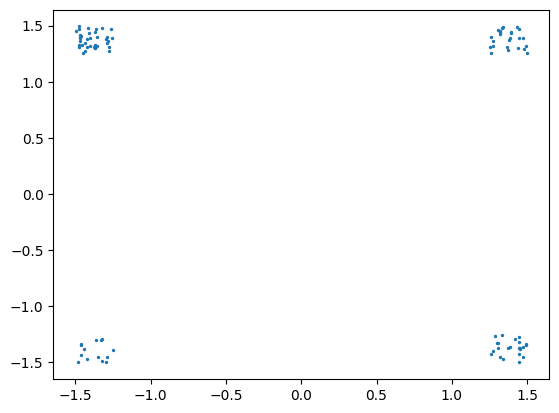

In [3]:
data_2d = sample_squares_2d(100)
plt.scatter(data_2d.data[:,0], data_2d.data[:,1], s=2)

In [4]:
def plot_1d_diffusion(XT, x_t=None, bins=601):
  """
  XT: torch.Tensor[T, x_t]
    A collection of diffusion trajectories.
  x_t: torch.Tensor[T]
    A single trajectory to highlight
  bins: int
    number of bins to compute densities
  """
  XT = XT.squeeze(-1)
  if x_t is not None:
    x_t = x_t.squeeze(-1)
  diffusion_steps = XT.shape[0]
  Y = torch.linspace(-3, 3, bins)
  Yr = torch.cat([Y, 3*torch.ones(1)])
  C = []
  T = torch.linspace(0, 1, diffusion_steps)
  for d in range(diffusion_steps):
    h = torch.histogram(XT[d,:].cpu(), bins=Yr.cpu(), density=True)
    C.append(h[0])
  C = torch.stack(C, dim=1)
  plt.pcolormesh(T, Y, C, shading='nearest')

  if x_t is not None:
    plt.plot(torch.linspace(0, 1, diffusion_steps), x_t, '-r')

## Forward process

In this part, we define the forward process.

As a reminder, the the update goes as follows:
$$x_t = \sqrt{1-\beta_t}\ x_{t-1} +  \sqrt{\beta_t}\ \epsilon$$
To do so, we'll first need to define a noise schedule $\beta_0 < \dots < \beta_T$.

Also, to train a diffusion model, we also need to be able to compute
$x_{t}$ directly from $x_0$, using the closed form formulation.

$x_t = \sqrt{\bar{\alpha}_t} \ x_0 + \sqrt{1-\bar{\alpha}_t}\ \epsilon$ where $\bar{\alpha}_t = \prod\limits_{s=1}^{t} {\alpha}_s$ and ${\alpha}_t = 1 - {\beta}_t$.




In [5]:
class DiffusionForwardProcess(nn.Module):
  def __init__(self, num_timesteps=1000, beta_1=0.00001, beta_T=0.02):
    super(DiffusionForwardProcess, self).__init__()
    self.num_timesteps = num_timesteps
    # TODO: create the beta schedule, and the corresponding schedule alpha
    # For simplicity, we can use a linear schedule, i.e. beta increases linearly over time.
    self.betas = torch.linspace(beta_1, beta_T, num_timesteps)
    self.alphas = 1. - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, dim = 0)

    # We'll also need to store the alphas and bar_alphas for later use


  def add_noise_step(self, x_t, epsilon, t):
    # TODO: compute and return x_{t+1} given x_t, epsilon, and t
    # Remember that we want this function to be able to operate on a batch of inputs
    # Consider what sizes each inputs needs to be.
    beta_t = self.betas[t].view(-1, 1)
    x_next = torch.sqrt(1 - beta_t) * x_t + torch.sqrt(beta_t) * epsilon

    return x_next

  def add_noise(self, x_0, epsilon, t):
    # TODO: compute and return x_{t} given x_0, epsilon, and t
    alpha_bar_t = self.alphas_cumprod[t].view(-1, 1)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * epsilon

    return x_t

## 1D Visualization

We can now get a batch of data from 1d data points, add iteratively add noise to it.

In [6]:
batch_size = 5000
num_timesteps = 1000
# TODO:
# Draw batch_size examples. Progressively add noise to them while storing the trajectories.
diffusion = DiffusionForwardProcess()
x_0 = sample_squares_1d(batch_size).to(device)

trajectories = torch.zeros((num_timesteps, batch_size, 1), device = device)
x_t = x_0.to(device)

for t in range(num_timesteps):
  eps = torch.randn_like(x_t)
  x_t = diffusion.add_noise_step(x_t, eps, t)
  trajectories[t] = x_t

This function plots a heatmap showing the distribution of values through time.
You can use it to visualize the forward diffusion process.

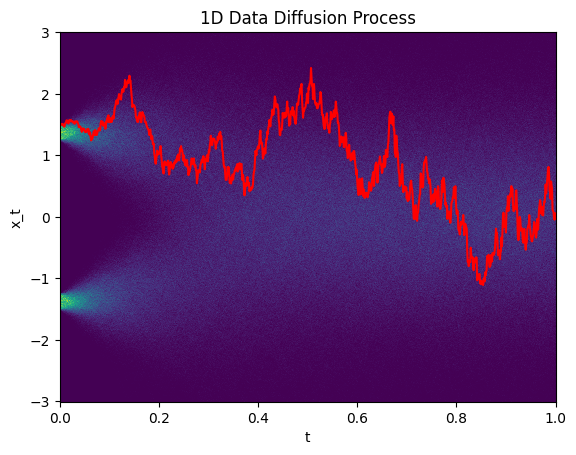

In [7]:
def plot_1d_diffusion(XT, x_t=None, bins=601):
  """
  XT: torch.Tensor[T, x_t]
    A collection of diffusion trajectories.
  x_t: torch.Tensor[T]
    A single trajectory to highlight
  bins: int
    number of bins to compute densities
  """
  XT = XT.squeeze(-1)
  if x_t is not None:
    x_t = x_t.squeeze(-1)
  diffusion_steps = XT.shape[0]
  Y = torch.linspace(-3, 3, bins)
  Yr = torch.cat([Y, 3*torch.ones(1)])
  C = []
  T = torch.linspace(0, 1, diffusion_steps)
  for d in range(diffusion_steps):
    h = torch.histogram(XT[d,:].cpu(), bins=Yr.cpu(), density=True)
    C.append(h[0])
  C = torch.stack(C, dim=1)
  plt.pcolormesh(T, Y, C, shading='nearest')

  plt.xlabel('t')
  plt.ylabel('x_t')
  if x_t is not None:
    plt.plot(torch.linspace(0, 1, diffusion_steps), x_t, '-r')

# TODO: Call plot_1d_diffusion to visualize the distribution of values through time.
# Also extract a trajectory to plot
# You'll probably need to process the trajectories to the expected format.
sample_index = 0
single_trajectory = trajectories[:, sample_index, :]

plot_1d_diffusion(trajectories.cpu(), single_trajectory.cpu())
plt.title("1D Data Diffusion Process")
plt.show()



As a sanity check, compute values of $x_t$ directly from $x_0$ and visualize the distribution. It should be similar to the previous plot.

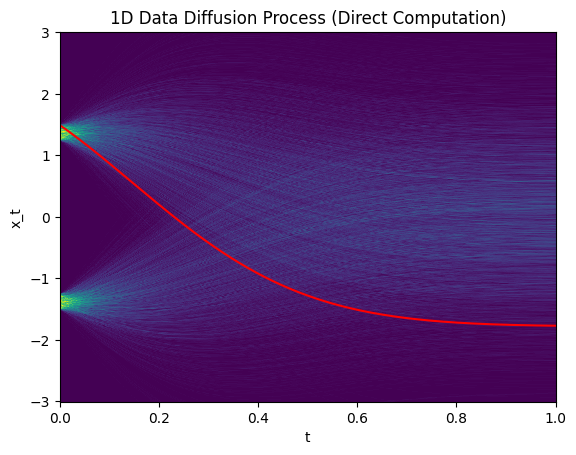

In [8]:
# TODO: Check if computing every x_t from x_0 gives the same distribution

# Generate Gaussian noise for all samples at once
eps_direct = torch.randn((batch_size, 1), device=device).expand(num_timesteps, -1, -1)

# Create time steps from 0 to T-1
timesteps = torch.arange(num_timesteps, device=device)

# Compute x_t for all time steps at once
alpha_bar_t = diffusion.alphas_cumprod[timesteps].view(-1, 1, 1)  # (num_timesteps, 1, 1)

# Compute x_t using the closed-form equation
x_t_direct = torch.sqrt(alpha_bar_t) * x_0.unsqueeze(0) + torch.sqrt(1 - alpha_bar_t) * eps_direct  # (num_timesteps, batch_size, 1)

# Extract a trajectory for comparison
single_trajectory_direct = x_t_direct[:, sample_index, :]

# Plot the direct diffusion process
plot_1d_diffusion(x_t_direct.cpu(), single_trajectory_direct.cpu())
plt.title("1D Data Diffusion Process (Direct Computation)")
plt.show()

In [9]:
timesteps_to_check = list(range(0, num_timesteps, 200))  # Every 200 steps

print(f"{'Timestep':<10} {'Stepwise Mean':<20} {'Direct Mean':<20} {'Stepwise Variance':<20} {'Direct Variance':<20}")
print("=" * 90)

for t_test in timesteps_to_check:
    every_check_t_iter = trajectories[t_test].flatten()
    every_check_t_direct = x_t_direct[t_test].flatten()

    print(f"{t_test:<10} {every_check_t_iter.mean():<20.6f} {every_check_t_direct.mean():<20.6f} {every_check_t_iter.var():<20.6f} {every_check_t_direct.var():<20.6f}")

Timestep   Stepwise Mean        Direct Mean          Stepwise Variance    Direct Variance     
0          0.015819             0.015803             1.893485             1.893675            
200        0.013098             0.010966             1.600442             1.617933            
400        -0.010352            0.004033             1.177794             1.185542            
600        0.001836             -0.000759            1.039445             1.012917            
800        -0.009923            -0.002751            0.976233             0.982628            


In [10]:
# Compute the mean and variance across all timesteps
mean_stepwise = trajectories.cpu().numpy().mean()
var_stepwise = trajectories.cpu().numpy().var()

mean_direct = x_t_direct.cpu().numpy().mean()
var_direct = x_t_direct.cpu().numpy().var()

# Print results
print("=" * 60)
print(f"{'Method':<20} {'Mean':<20} {'Variance':<20}")
print("=" * 60)
print(f"{'Iterative Diffusion':<20} {mean_stepwise:.6f} {var_stepwise:.6f}")
print(f"{'Direct Diffusion':<20} {mean_direct:.6f} {var_direct:.6f}")
print("=" * 60)

Method               Mean                 Variance            
Iterative Diffusion  -0.001150 1.247865
Direct Diffusion     0.003526 1.247960


The above result demonstrates the similarity between the two plots.

## 2D Visualization

We can now apply the forward process the the 2d data.

In [11]:
batch_size = 6
# TODO:
# Draw batch_size examples. Progressively add noise to them while storing the trajectories.
x_0_2d = sample_squares_2d(batch_size).to(device)

trajectories_2d = torch.zeros((num_timesteps, batch_size, 2), device = device)
x_t_2d = x_0_2d.to(device)

diffusion_2d = DiffusionForwardProcess()

for t in range(num_timesteps):
  eps_2d = torch.randn_like(x_t_2d)
  x_t_2d = diffusion_2d.add_noise_step(x_t_2d, eps_2d, t)
  trajectories_2d[t] = x_t_2d

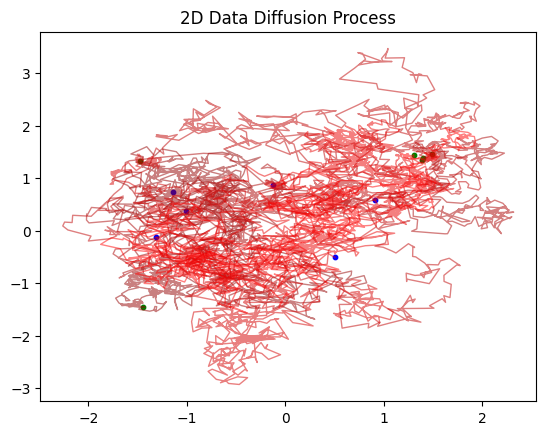

In [12]:
def plot_2d_trajectories(XT):
  """
  XT: torch.Tensor[T, x_t, d=2]
    A collection of diffusion trajectories.
  """

  nb_particles = XT.shape[1]
  for i in range(nb_particles):
    color = np.array([0.5, 0., 0.]) + (i+1)/nb_particles*0.5*np.array([1., 0., 0.])
    plt.plot(XT[:,i,0], XT[:,i,1], '-', color=color, linewidth=1, alpha=.5)

  plt.scatter(XT[-1,:nb_particles,0], XT[-1,:nb_particles,1], c='b', s=10)
  plt.scatter(XT[0,:nb_particles,0], XT[0,:nb_particles,1], c='g', s=10)

# TODO: plot the trajectories in 2d
plot_2d_trajectories(trajectories_2d.cpu())
plt.title("2D Data Diffusion Process")
plt.show()

## Reverse process (denoising)

We now want to train a neural network for reverse diffusion following the DDPM algorithm.

Let's start by implementing the sampling method.

### Sampling

For sampling, we follow the iterative procedure:
$$x_{t-1} = \frac{1}{\sqrt\alpha_t} \left[ x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \ \epsilon_\theta(x_t,t) \right] + z \ \sigma_z$$
where $z$ is additional noise and $\sigma_z$ its std.

We can first augment the DiffusionForwardProcess class with the denoising step.

In [13]:
class DDPM(DiffusionForwardProcess):
  ''' Inheriting from the previously implemented DiffusionForwardProcess
      gives us access to all its attributes and methods
  '''
  def __init__(self, num_timesteps=1000, beta_start=0.00001, beta_end=0.02):
    super(DDPM, self).__init__(num_timesteps, beta_start, beta_end)

  def denoise_step(self, x_t, predicted_eps, t, sigma_z=0):
    # TODO: compute and return x_{t-1} given x_{t}, epsilon, t, and sigma

    if isinstance(t, int):
      t = torch.tensor([t], device=x_t.device)

    alpha_t = self.alphas[t].view(-1, *(1,) * (x_t.dim() - 1))  # Shape: (batch_size, 1, 1)
    alpha_bar_t = self.alphas_cumprod[t].view(-1, *(1,) * (x_t.dim() - 1))  # Shape: (batch_size, 1, 1)

    # Compute x_{t-1}
    x_prev = (1 / torch.sqrt(alpha_t)) * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_eps)

    # Add stochastic noise if sigma_z > 0
    if sigma_z > 0:
        z = torch.randn_like(x_t)  # Generate standard Gaussian noise
        x_prev += sigma_z * z  # Add noise to the denoised step

    return x_prev



We also define a simple neural network.

In [14]:
class NoisePredictor(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_layers, num_timesteps):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_timesteps = num_timesteps
    self.in_proj = nn.Linear(in_dim, hidden_dim)
    self.layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for l in range(n_layers)])
    self.scale = nn.Parameter(torch.zeros((n_layers, 1, hidden_dim,)), requires_grad=True)
    self.out_proj = nn.Linear(hidden_dim, 2)
    self.t_emb = nn.Embedding(num_timesteps, hidden_dim)

    for l in self.layers:
      nn.init.xavier_uniform_(l.weight)
      nn.init.zeros_(l.bias)
    nn.init.zeros_(self.out_proj.weight)
    nn.init.zeros_(self.out_proj.bias)

  def forward(self, x, t):
    x = self.in_proj(x)
    t = self.t_emb(t)
    x = x + 0.1 * t
    for i, l in enumerate(self.layers):
      x = x + self.scale[i]*F.gelu(l(x))
    x = self.out_proj(x)
    return x

We instantiate the network

In [15]:
model = NoisePredictor(2, 64, 4, num_timesteps=1000).to(device)
optimizer = AdamW(model.parameters(), lr=0.001)
ddpm = DDPM()

### Training

#### Compute loss

We now need to define a training step.
The algorithm goes as follows:

1 - sample data points $x_0$

2 - sample noise $\epsilon$

3 - sample timestep $t$

4 - Minimize $\mathbb{E}_{t, x_0, \epsilon} || \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t} \ x_0 + \sqrt{1-\bar{\alpha}_t}\ \epsilon, t) ||$



In [16]:
def compute_loss(X0, model, diffusion_process):
  # TODO: Given a mini-batch of clean data, the function should return the loss, the predicted noise, and the inputs $x_t$ and $t$.
  batch_size = X0.shape[0]
  # Sample random timesteps t
  t = torch.randint(0, diffusion_process.num_timesteps, (batch_size,)).to(device)
  # Sample Gaussian noise 𝜖
  eps = torch.randn_like(X0)
  # Apply forward diffusion to get noisy x_t
  xt = diffusion_process.add_noise(X0, eps, t)
  xt = xt.view_as(X0)
  # Predict noise using the model
  pred_eps = model(xt, t)
  pred_eps = pred_eps.view_as(X0)
  # Compute the loss
  loss = F.mse_loss(pred_eps, eps)

  return loss, pred_eps, xt, t

Run the training loop

In [17]:
def visualize_training(x0, xt, pred_eps, diffusion_process):
    ''' visualization fonction '''
    x0 = x0.cpu()
    xt = xt.cpu()
    pred_eps = pred_eps.detach()
    pred_xprev = diffusion_process.denoise_step(xt, pred_eps, t)
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(l)
    ax2.scatter(x0[:,0], x0[:,1])
    ax2.scatter(xt[:,0], xt[:,1])
    ax2.scatter(pred_xprev[:,0], pred_xprev[:,1])
    for i in range(len(xt)):
      ax2.plot([xt[i, 0], pred_xprev[i, 0]], [xt[i, 1], pred_xprev[i, 1]], 'k-', linewidth=1)
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    plt.show()

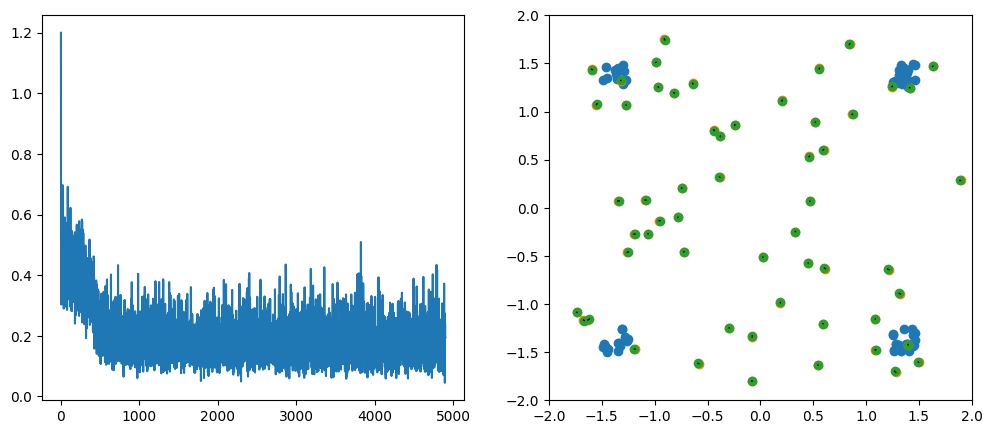

In [18]:
batch_size = 64
n_iterations = 50000
l = []
for i in range(n_iterations):
  x0 = sample_squares_2d(batch_size).to(device)
  optimizer.zero_grad()
  loss, pred_eps, xt, t = compute_loss(x0, model, ddpm)
  loss.backward()
  optimizer.step()
  if i % 10 == 0:
    l.append(loss.item())
  if i > 0 and i % 1000 == 0:
    visualize_training(x0, xt, pred_eps, ddpm)


In [19]:
print(f"x0 shape: {x0.shape}")  # Expected (batch_size, 2)
print(f"xt shape: {xt.shape}")  # Should be (batch_size, 2)
print(f"pred_eps shape: {pred_eps.shape}")  # Should be (batch_size, 2)

x0 shape: torch.Size([64, 2])
xt shape: torch.Size([64, 2])
pred_eps shape: torch.Size([64, 2])


## Inference Visualization

Run the visualization

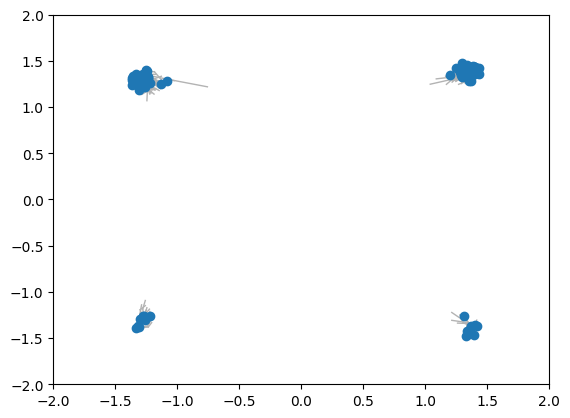

In [20]:
def inference_visualization(x0, model, diffusion_process, sigma=0.01):
  model = model.to("cpu")
  bs = x0.shape[0]
  xt = torch.randn((bs, 2))
  xp = xt
  xp1 = xp
  xp2 = xp1
  for t in torch.arange(2, diffusion_process.num_timesteps):
    t = (diffusion_process.num_timesteps-1 - t)*torch.ones((bs,)).long()
    pred_eps = model(xt, t).detach()
    xt = diffusion_process.denoise_step(xt, pred_eps, t, sigma)
    if t[0] % 25 == 0:
      clear_output(wait=True)
      for i in range(len(xt)):
        plt.plot([xp[i, 0], xt[i, 0]], [xp[i, 1], xt[i, 1]], 'k-', linewidth=1)
        plt.plot([xp[i, 0], xp1[i, 0]], [xp[i, 1], xp1[i, 1]], 'k-', linewidth=1)
        plt.plot([xp2[i, 0], xp1[i, 0]], [xp2[i, 1], xp1[i, 1]], 'k-', linewidth=1)
      # plt.scatter(xp[:,0], xp[:,1])
      plt.scatter(xt[:,0], xt[:,1])
      plt.scatter(x0[:,0], x0[:,1])
      plt.xlim(-2, 2)
      plt.ylim(-2, 2)
      plt.show()
      xp2 = xp1
      xp1= xp
      xp = xt

  clear_output(wait=True)
  for i in range(len(xt)):
    plt.plot([xp[i, 0], xt[i, 0]], [xp[i, 1], xt[i, 1]], '-', color='0.7', linewidth=1)
    plt.plot([xp[i, 0], xp1[i, 0]], [xp[i, 1], xp1[i, 1]], '-', color='0.7', linewidth=1)
    plt.plot([xp2[i, 0], xp1[i, 0]], [xp2[i, 1], xp1[i, 1]], '-', color='0.7', linewidth=1)
  plt.scatter(xt[:,0], xt[:,1], zorder=5)
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)
  plt.show()

x0 = sample_squares_2d(128)
diffusion_process = DDPM(1000)
model = model.to("cpu")
inference_visualization(x0, model, ddpm)